###dsadsad

In [1]:
import sys
import os
sys.path.append('../')

from app.config import settings
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent

from langchain_core.tools import tool
from geopy.geocoders import Nominatim
from pydantic import BaseModel, Field
import requests

from typing import Annotated,Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages # helper function to add messages to the state


class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

In [2]:
from langchain_core.tools import tool
from geopy.geocoders import Nominatim
from pydantic import BaseModel, Field
import requests

geolocator = Nominatim(user_agent="weather-app")

class SearchInput(BaseModel):
    location:str = Field(description="The city and state, e.g., San Francisco")
    date:str = Field(description="the forecasting date for when to get the weather format (yyyy-mm-dd)")

@tool("get_weather_forecast", args_schema=SearchInput, return_direct=True)
def get_weather_forecast(location: str, date: str):
    """Retrieves the weather using Open-Meteo API for a given location (city) and a date (yyyy-mm-dd). Returns a list dictionary with the time and temperature for each hour."""
    location = geolocator.geocode(location)
    if location:
        try:
            response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={location.latitude}&longitude={location.longitude}&hourly=temperature_2m&start_date={date}&end_date={date}")
            data = response.json()
            return {time: temp for time, temp in zip(data["hourly"]["time"], data["hourly"]["temperature_2m"])}
        except Exception as e:
            return {"error": str(e)}
    else:
        return {"error": "Location not found"}

tools = [get_weather_forecast]

In [3]:
from datetime import datetime
from langchain_google_genai import ChatGoogleGenerativeAI

# Create LLM class
llm = ChatGoogleGenerativeAI(
    model= "gemini-2.0-flash",
    temperature=1.0,
    max_retries=2,
    google_api_key=settings.gemini_api_key,
)

# Bind tools to the model
model = llm.bind_tools([get_weather_forecast])

# Test the model with tools
res=model.invoke(f"What is the weather in Berlin on {datetime.today()}?")

print(res)

content='' additional_kwargs={'function_call': {'name': 'get_weather_forecast', 'arguments': '{"date": "2025-06-26", "location": "Berlin"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--ce377ba1-f203-4ca8-ae38-ab0cb24774a5-0' tool_calls=[{'name': 'get_weather_forecast', 'args': {'date': '2025-06-26', 'location': 'Berlin'}, 'id': 'a5f43c0d-b0c6-4270-acc3-160a31eb9f49', 'type': 'tool_call'}] usage_metadata={'input_tokens': 115, 'output_tokens': 18, 'total_tokens': 133, 'input_token_details': {'cache_read': 0}}


In [6]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}

# Define our tool node
def call_tool(state: AgentState):
    outputs = []
    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool by name
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # Invoke the model with the system prompt and the messages
    response = model.invoke(state["messages"], config)
    # We return a list, because this will get added to the existing messages state using the add_messages reducer
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # If the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
    # default to continue
    return "continue"

In [7]:
from langgraph.graph import StateGraph, END

# Define a new graph with our state
workflow = StateGraph(AgentState)

# 1. Add our nodes 
workflow.add_node("llm", call_model)
workflow.add_node("tools",  call_tool)
# 2. Set the entrypoint as `agent`, this is the first node called
workflow.set_entry_point("llm")
# 3. Add a conditional edge after the `llm` node is called.
workflow.add_conditional_edges(
    # Edge is used after the `llm` node is called.
    "llm",
    # The function that will determine which node is called next.
    should_continue,
    # Mapping for where to go next, keys are strings from the function return, and the values are other nodes.
    # END is a special node marking that the graph is finish.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)
# 4. Add a normal edge after `tools` is called, `llm` node is called next.
workflow.add_edge("tools", "llm")

# Now we can compile and visualize our graph
graph = workflow.compile()

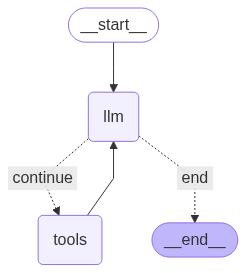

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
from datetime import datetime
# Create our initial message dictionary
inputs = {"messages": [("user", f"What is the weather in Berlin on {datetime.today()}?")]}

# call our graph with streaming to see the steps
for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

What is the weather in Berlin on 2025-06-26 00:03:02.266459?
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (c3660919-51ac-469b-978d-06d7b3926c38)
 Call ID: c3660919-51ac-469b-978d-06d7b3926c38
  Args:
    date: 2025-06-26
    location: Berlin
================================= Tool Message =================================
Name: get_weather_forecast

{'2025-06-26T00:00': 17.4, '2025-06-26T01:00': 17.0, '2025-06-26T02:00': 16.5, '2025-06-26T03:00': 16.0, '2025-06-26T04:00': 16.1, '2025-06-26T05:00': 16.9, '2025-06-26T06:00': 18.4, '2025-06-26T07:00': 20.3, '2025-06-26T08:00': 22.4, '2025-06-26T09:00': 23.4, '2025-06-26T10:00': 24.3, '2025-06-26T11:00': 25.4, '2025-06-26T12:00': 27.3, '2025-06-26T13:00': 28.6, '2025-06-26T14:00': 30.3, '2025-06-26T15:00': 31.3, '2025-06-26T16:00': 31.3, '2025-06-26T17:00': 25.1, '2025-06-26T18:00': 22.7, '